## Preparing/Cleaning up the h5ad objects for the Cellxgene instances (web portal)

- last updated: 09/18/2024
- Yang-Joon Kim (yang-joon.kim@czbiohub.org)

Goals: we clean up the h5ad objects to generate cellxgene instnaces in the Zebrahub web portal. The datasets are the following, and are from "integrated" across all timepoints:
- (1) RNA object (cells-by-genes), with 3 embeddings (UMAPs from RNA, ATAC, and joint)
- (2) ATAC object (cells-by-gene.activity), with 3 embeddings
- (3) joint object (cells-by-genes&gene.activity), with 3 embeddings



In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### import h5ad objects


In [2]:
adata_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/"

# RNA object
adata_RNA = sc.read_h5ad(adata_path + "integrated_RNA_ATAC_counts_RNA_master_filtered.h5ad")

# ATAC object
adata_ATAC = sc.read_h5ad(adata_path + "integrated_RNA_ATAC_counts_gene_activity_raw_counts_master_filtered.h5ad")


### (1) RNA object

In [3]:
adata_RNA

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    layers: 'counts'

In [18]:
adata_RNA

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'developmental_stage', 'dataset', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc'
    var: 'features', 'mt', 'nc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'assay'
    uns: 'dataset_colors', 'log1p', 'zebrafish_anatomy_ontology_class_coarse_colors', 'zebrafish_anatomy_ontology_class_colors'
    obsm: 'X_umap_atac', 'X_umap_joint', 'X_umap_rna'
    layers: 'counts'

In [20]:
print(np.median(adata_RNA.obs.n_genes_by_counts))
print(np.median(adata_RNA.obs.total_counts))

1404.0
3703.0


In [21]:
adata_ATAC

AnnData object with n_obs × n_vars = 94562 × 25032
    obs: 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'n_counts_ATAC', 'n_peaks_by_counts_ATAC', 'developmental_stage', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'assay'
    uns: 'log1p', 'zebrafish_anatomy_ontology_class_coarse_colors'
    obsm: 'X_umap_atac', 'X_umap_joint', 'X_umap_rna'
    layers: 'counts'

In [23]:
print(np.median(adata_ATAC.obs.n_peaks_by_counts_ATAC))
print(np.median(adata_ATAC.obs.n_counts_ATAC))

15368.0
18634.0


In [8]:
# Step 1. define the fields to keep
fields_RNA = ["dev_stage", "dataset", "annotation_ML", "annotation_ML_coarse"]

# clean up the obs fields (and also uns slot), and re-name them
adata_RNA.obs = adata_RNA.obs[fields_RNA]
adata_RNA

# rename the obsm fields
dict_names = {"dev_stage":"developmental_stage",
              "dataset":"dataset",
              "annotation_ML_coarse":"zebrafish_anatomy_ontology_class_coarse",
              "annotation_ML":"zebrafish_anatomy_ontology_class"}

# Step 2. Rename the columns in adata_RNA.obs using the dictionary
adata_RNA.obs = adata_RNA.obs.rename(columns=dict_names)

# Dictionary mapping dev_stage to real time (hpf)
dev_stage_to_hpf = {
    '0somites': '10hpf',
    '5somites': '12hpf',
    '10somites': '14hpf',
    '15somites': '16hpf',
    '20somites': '19hpf',
    '30somites': '24hpf'
}

adata_RNA.obs["timepoint"] = adata_RNA.obs.developmental_stage.map(dev_stage_to_hpf)
adata_RNA.obs.head()

,developmental_stage,dataset,zebrafish_anatomy_ontology_class,zebrafish_anatomy_ontology_class_coarse,timepoint
AAACAGCCACCTAAGC-1_1,15somites,TDR118,epidermis,epidermis,16hpf
AAACAGCCAGGGAGGA-1_1,15somites,TDR118,pronephros,pronephros,16hpf
AAACAGCCATAGACCC-1_1,15somites,TDR118,hindbrain,hindbrain,16hpf
AAACATGCAAACTCAT-1_1,15somites,TDR118,spinal_cord,spinal_cord,16hpf
AAACATGCAAGGACCA-1_1,15somites,TDR118,neural_optic2,neural_optic,16hpf


In [9]:
adata_RNA

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'developmental_stage', 'dataset', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    layers: 'counts'

In [10]:
# Step 3: Rename obsm fields
obsm_rename_dict = {'X_umap.atac': 'X_umap_atac', 
                    'X_umap.rna': 'X_umap_rna', 
                    'X_wnn.umap': 'X_umap_joint'}

for old_key, new_key in obsm_rename_dict.items():
    adata_RNA.obsm[new_key] = adata_RNA.obsm.pop(old_key)

In [11]:
# Dictionary for renaming the relevant fields in adata_RNA.uns
uns_dict_names = {
    "annotation_ML_coarse_colors": "zebrafish_anatomy_ontology_class_coarse_colors",
    "annotation_ML_colors": "zebrafish_anatomy_ontology_class_colors",
    "dataset_colors": "dataset_colors"
}

# Step 2: Remove all fields from adata_RNA.uns except the first three and rename them
# Create a new dictionary with only the fields to keep
adata_RNA.uns = {new_key: adata_RNA.uns.pop(old_key) for old_key, new_key in uns_dict_names.items() if old_key in adata_RNA.uns}

# Step 3: Check the resulting adata_RNA.uns
adata_RNA

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'developmental_stage', 'dataset', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint'
    var: 'features'
    uns: 'zebrafish_anatomy_ontology_class_coarse_colors', 'zebrafish_anatomy_ontology_class_colors', 'dataset_colors'
    obsm: 'X_umap_atac', 'X_umap_rna', 'X_umap_joint'
    layers: 'counts'

In [12]:
adata_RNA.var_names

Index(['ptpn12', 'phtf2', 'phtf2.1', 'CU856344.1', 'si:zfos-932h1.3', 'mansc1',
       'lrp6', 'dusp16', 'crebl2', 'gpr19',
       ...
       'mt-nd4', 'NC-002333.16', 'NC-002333.15', 'NC-002333.8', 'mt-nd5',
       'mt-nd6', 'NC-002333.21', 'mt-cyb', 'NC-002333.22', 'NC-002333.11'],
      dtype='object', length=32057)

In [13]:
# annotate the group of mitochondrial genes as "mt"m or "NC"
adata_RNA.var["mt"] = adata_RNA.var_names.str.startswith("mt-")
adata_RNA.var["nc"] = adata_RNA.var_names.str.startswith("NC-")

# recompute the QC metrics (for raw counts)
adata_RNA.X = adata_RNA.layers["counts"].copy()

sc.pp.calculate_qc_metrics(
    adata_RNA, qc_vars=["mt","nc"], percent_top=None, log1p=False, inplace=True
)

sc.pp.normalize_total(adata_RNA, target_sum=1e4)
sc.pp.log1p(adata_RNA)



/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1107: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword

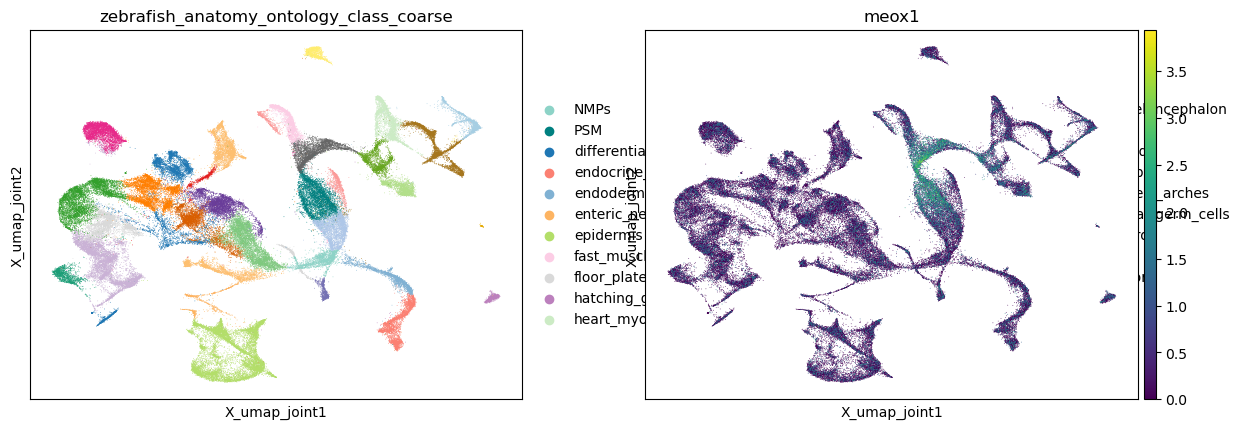

In [15]:
sc.pl.embedding(adata_RNA, basis="X_umap_joint", color=["zebrafish_anatomy_ontology_class_coarse","meox1"])

In [17]:
adata_RNA

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'developmental_stage', 'dataset', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc'
    var: 'features', 'mt', 'nc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'zebrafish_anatomy_ontology_class_coarse_colors', 'zebrafish_anatomy_ontology_class_colors', 'dataset_colors', 'log1p'
    obsm: 'X_umap_atac', 'X_umap_rna', 'X_umap_joint'
    layers: 'counts'

In [16]:
# save the object
adata_RNA.write_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/zebrahub_multiome_v1_release/zf_multiome_atlas_full_RNA_v1_release.h5ad")

### (2) ATAC object

In [4]:
adata_ATAC

AnnData object with n_obs × n_vars = 94562 × 25032
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters'
    var: 'features'
    obsm: 'X_umap', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    layers: 'counts'

In [7]:
# copy over the fields from adata_RNA
fields_to_copy = ['developmental_stage', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse']

# Copy over the fields from adata_RNA to adata_ATAC
cell_ids = adata_RNA.obs_names
for field in fields_to_copy:
    adata_ATAC.obs.loc[cell_ids, field] = adata_RNA.obs.loc[cell_ids, field]

    
adata_ATAC

AnnData object with n_obs × n_vars = 94562 × 25032
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'developmental_stage', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse'
    var: 'features'
    obsm: 'X_umap', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    layers: 'counts'

In [8]:
# Step 1. define the fields to keep
fields_ATAC = ['nucleosome_signal', 'nucleosome_percentile', 
               'TSS_enrichment', 'TSS_percentile',
               'nCount_peaks_integrated', 'nFeature_peaks_integrated',
               'developmental_stage', 'zebrafish_anatomy_ontology_class', 
               'zebrafish_anatomy_ontology_class_coarse']

# clean up the obs fields (and also uns slot), and re-name them
adata_ATAC.obs = adata_ATAC.obs[fields_ATAC]
adata_ATAC

# rename the obs fields
dict_names = {"nCount_peaks_integrated":"n_counts_ATAC",
              "nFeature_peaks_integrated":"n_peaks_by_counts_ATAC"}

# Step 2. Rename the columns in adata_RNA.obs using the dictionary
adata_ATAC.obs = adata_ATAC.obs.rename(columns=dict_names)

# Dictionary mapping dev_stage to real time (hpf)
dev_stage_to_hpf = {
    '0somites': '10hpf',
    '5somites': '12hpf',
    '10somites': '14hpf',
    '15somites': '16hpf',
    '20somites': '19hpf',
    '30somites': '24hpf'
}

adata_ATAC.obs["timepoint"] = adata_ATAC.obs.developmental_stage.map(dev_stage_to_hpf)
adata_ATAC.obs.head()

,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,n_counts_ATAC,n_peaks_by_counts_ATAC,developmental_stage,zebrafish_anatomy_ontology_class,zebrafish_anatomy_ontology_class_coarse,timepoint
AAACAGCCACCTAAGC-1_1,0.571984,0.40,4.488213,0.48,13987.0,11974,15somites,epidermis,epidermis,16hpf
AAACAGCCAGGGAGGA-1_1,0.448143,0.13,4.795205,0.75,6889.0,6302,15somites,pronephros,pronephros,16hpf
AAACAGCCATAGACCC-1_1,0.514213,0.24,5.238692,0.92,32040.0,23386,15somites,hindbrain,hindbrain,16hpf
AAACATGCAAACTCAT-1_1,0.673319,0.85,4.409525,0.41,13090.0,11254,15somites,spinal_cord,spinal_cord,16hpf
AAACATGCAAGGACCA-1_1,0.394904,0.06,4.939061,0.83,3390.0,3149,15somites,neural_optic2,neural_optic,16hpf


In [9]:
# Step 3: Rename obsm fields
obsm_rename_dict = {'X_umap.atac': 'X_umap_atac', 
                    'X_umap.rna': 'X_umap_rna', 
                    'X_wnn.umap': 'X_umap_joint'}

for old_key, new_key in obsm_rename_dict.items():
    adata_ATAC.obsm[new_key] = adata_ATAC.obsm.pop(old_key)
    
del adata_ATAC.obsm["X_umap"]

adata_ATAC

AnnData object with n_obs × n_vars = 94562 × 25032
    obs: 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'n_counts_ATAC', 'n_peaks_by_counts_ATAC', 'developmental_stage', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint'
    var: 'features'
    obsm: 'X_umap_atac', 'X_umap_rna', 'X_umap_joint'
    layers: 'counts'

In [10]:
adata_ATAC.var_names

Index(['ptpn12', 'phtf2', 'phtf2.1', 'CU856344.1', 'si:zfos-932h1.3', 'mansc1',
       'lrp6', 'dusp16', 'crebl2', 'gpr19',
       ...
       'mt-co2', 'mt-atp8', 'mt-atp6', 'mt-co3', 'mt-nd3', 'mt-nd4l', 'mt-nd4',
       'mt-nd5', 'mt-nd6', 'mt-cyb'],
      dtype='object', length=25032)

In [12]:
# annotate the group of mitochondrial genes as "mt"m or "NC"
adata_ATAC.var["mt"] = adata_ATAC.var_names.str.startswith("mt-")
# adata_ATAC.var["nc"] = adata_ATAC.var_names.str.startswith("NC-")

# recompute the QC metrics (for raw counts)
adata_ATAC.X = adata_ATAC.layers["counts"].copy()

sc.pp.calculate_qc_metrics(
    adata_ATAC, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pp.normalize_total(adata_ATAC, target_sum=1e4)
sc.pp.log1p(adata_ATAC)



/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


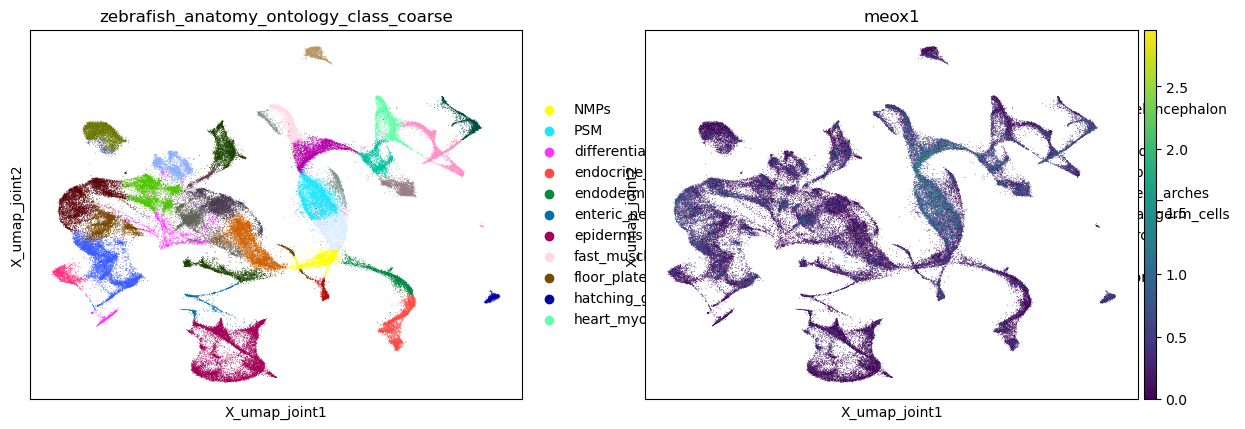

In [13]:
sc.pl.embedding(adata_ATAC, basis="X_umap_joint", color=["zebrafish_anatomy_ontology_class_coarse","meox1"])

In [14]:
# save the adata_ATAC
adata_ATAC.write_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/zebrahub_multiome_v1_release/zf_multiome_atlas_full_ATAC_gene_activity_v1_release.h5ad")

### (3) combining RNA and ATAC objects -

- need to change the var_names ("-RNA", or "-ATAC")
- concatenate the count matrices
- keep the obs fields as the union
- keep the obsm as the same


In [4]:
# resumption from here - loading the h5ad objects cleaned up in the above code cells
# RNA object
adata_RNA = sc.read_h5ad(adata_path + "zebrahub_multiome_v1_release/zf_multiome_atlas_full_RNA_v1_release.h5ad")

# ATAC object
adata_ATAC = sc.read_h5ad(adata_path + "zebrahub_multiome_v1_release/zf_multiome_atlas_full_ATAC_gene_activity_v1_release.h5ad")


In [5]:
adata_RNA

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'developmental_stage', 'dataset', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc'
    var: 'features', 'mt', 'nc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'dataset_colors', 'log1p', 'zebrafish_anatomy_ontology_class_coarse_colors', 'zebrafish_anatomy_ontology_class_colors'
    obsm: 'X_umap_atac', 'X_umap_joint', 'X_umap_rna'
    layers: 'counts'

In [6]:
adata_ATAC

AnnData object with n_obs × n_vars = 94562 × 25032
    obs: 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'n_counts_ATAC', 'n_peaks_by_counts_ATAC', 'developmental_stage', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'zebrafish_anatomy_ontology_class_coarse_colors'
    obsm: 'X_umap_atac', 'X_umap_joint', 'X_umap_rna'
    layers: 'counts'

In [9]:
# change the var names in adata_RNA
adata_RNA.var_names = adata_RNA.var_names + "-RNA"
adata_RNA.var_names

# change the var names in adata_ATAC_genes
adata_ATAC.var_names = adata_ATAC.var_names + "-ATAC"
adata_ATAC.var_names

Index(['ptpn12-ATAC', 'phtf2-ATAC', 'phtf2.1-ATAC', 'CU856344.1-ATAC',
       'si:zfos-932h1.3-ATAC', 'mansc1-ATAC', 'lrp6-ATAC', 'dusp16-ATAC',
       'crebl2-ATAC', 'gpr19-ATAC',
       ...
       'mt-co2-ATAC', 'mt-atp8-ATAC', 'mt-atp6-ATAC', 'mt-co3-ATAC',
       'mt-nd3-ATAC', 'mt-nd4l-ATAC', 'mt-nd4-ATAC', 'mt-nd5-ATAC',
       'mt-nd6-ATAC', 'mt-cyb-ATAC'],
      dtype='object', length=25032)

In [13]:
adata_RNA

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'developmental_stage', 'dataset', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc'
    var: 'features', 'mt', 'nc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'assay'
    uns: 'dataset_colors', 'log1p', 'zebrafish_anatomy_ontology_class_coarse_colors', 'zebrafish_anatomy_ontology_class_colors'
    obsm: 'X_umap_atac', 'X_umap_joint', 'X_umap_rna'
    layers: 'counts'

In [12]:
import anndata as ad

# Put the assay name for adata.var just in case we need to differentiate where the marker comes from (usually it shoudl be obvious!)
adata_RNA.var['assay'] = 'RNA'
adata_ATAC.var['assay'] = 'ATAC'

# NOTE: the order of the adata.obs should matter in terms of concatenation (which is weird), 
# so we'd need to sort the orders of both adata objects before the concatenation (done in the previous step)

# concatenate the two adata objects
adata_joint = ad.concat([adata_RNA, adata_ATAC], axis=1, merge="first")

adata_joint

AnnData object with n_obs × n_vars = 94562 × 57089
    obs: 'developmental_stage', 'dataset', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'n_counts_ATAC', 'n_peaks_by_counts_ATAC'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'assay'
    obsm: 'X_umap_atac', 'X_umap_joint', 'X_umap_rna'
    layers: 'counts'

In [15]:
fields_to_remove = ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'n_counts_ATAC', 'n_peaks_by_counts_ATAC']
# Remove the fields from adata.obs if they exist
adata_joint.obs = adata_joint.obs.drop(columns=[field for field in fields_to_remove if field in adata_joint.obs.columns])

adata_joint

AnnData object with n_obs × n_vars = 94562 × 57089
    obs: 'developmental_stage', 'dataset', 'zebrafish_anatomy_ontology_class', 'zebrafish_anatomy_ontology_class_coarse', 'timepoint'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'assay'
    obsm: 'X_umap_atac', 'X_umap_joint', 'X_umap_rna'
    layers: 'counts'

/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to a

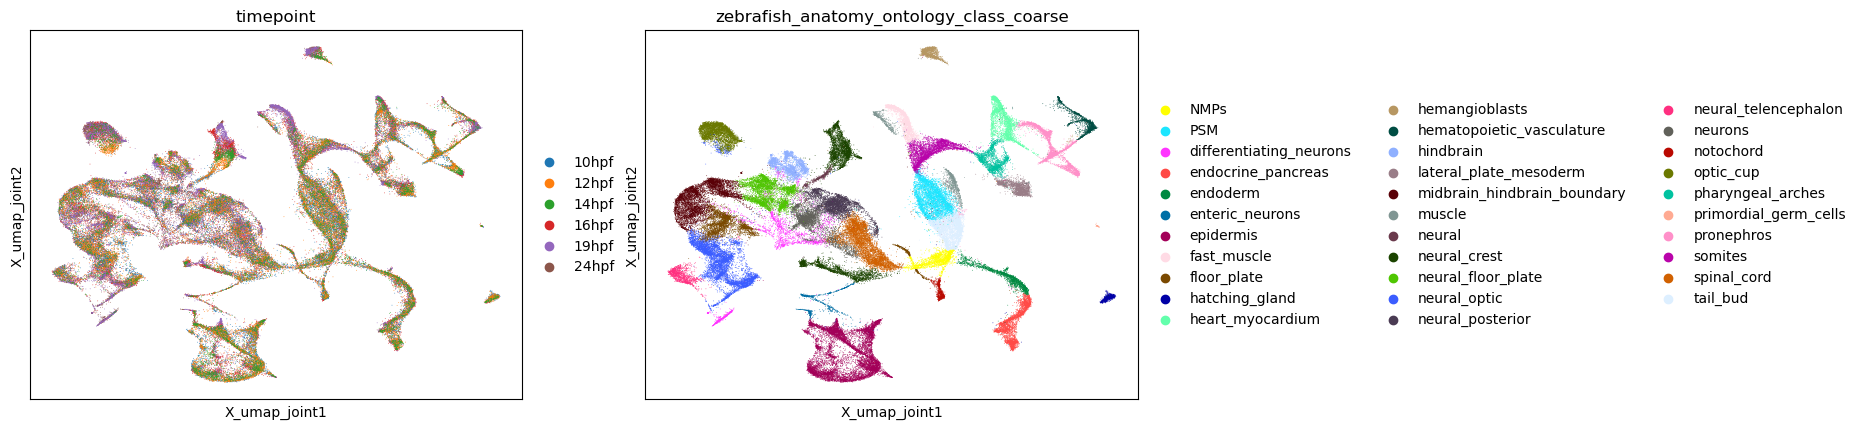

In [16]:
sc.pl.embedding(adata_joint, basis="X_umap_joint", color=["timepoint","zebrafish_anatomy_ontology_class_coarse"])

In [17]:
adata_joint.write_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/zebrahub_multiome_v1_release/zf_multiome_atlas_full_RNA_ATAC_concat_v1_release.h5ad")